# Testing new CM2-025 run (updated bathymetry and interpolation weights)

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.gridspec as gridspec
%matplotlib inline
import glob

import xgcm

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46417,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:46455,Total threads: 4
Dashboard: /proxy/34523/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:33217,


In [3]:
path_data = '/scratch/x77/wgh581/archive/cz861/history/ocn/'

In [4]:
# Monthly data
path_ocean_month = np.sort(glob.glob(path_data + 'ocean_month-ym*'))
path_ocean_ym    = np.sort(glob.glob(path_data + 'ocean-ym*'))

# data_month = xr.open_dataset(path_data + 'ocean_month-ym_0001_01.nc')
# for ii in range(1, len(path_ocean_month)):
#     data_month = xr.concat([data_month, xr.open_dataset(path_ocean_month[ii])], dim='time')

In [25]:
data_scalar = xr.open_dataset(path_data + 'ocean_scalar-ym_0001_01.nc')
data_scalar

<xarray.Dataset>
Dimensions:                            (scalar_axis: 1, time: 6, nv: 2)
Coordinates:
  * scalar_axis                        (scalar_axis) float64 0.0
  * time                               (time) object 0001-01-16 12:00:00 ... ...
  * nv                                 (nv) float64 1.0 2.0
Data variables: (12/37)
    ke_tot                             (time, scalar_axis) float64 ...
    pe_tot                             (time, scalar_axis) float64 ...
    temp_global_ave                    (time, scalar_axis) float64 ...
    salt_global_ave                    (time, scalar_axis) float64 ...
    rhoave                             (time, scalar_axis) float64 ...
    temp_surface_ave                   (time, scalar_axis) float64 ...
    ...                                 ...
    total_ocean_calving_melt_heat      (time, scalar_axis) float64 ...
    total_ocean_sens_heat              (time, scalar_axis) float64 ...
    average_T1                         (time) object ...
    average_T2                         (time) object ...
    average_DT                         (time) timedelta64[ns] ...
    time_bnds                          (time, nv) timedelta64[ns] ...
Attributes:
    filename:   HISTORY/ocean_scalar-ym_0001_01.nc
    title:      ACCESS-OM2-025
    grid_type:  mosaic
    grid_tile:  1
    history:    Thu Oct 26 06:52:50 2023: ncatted -a calendar,time,m,c,prolep...
    NCO:        netCDF Operators version 5.0.5 (Homepage = http://nco.sf.net,...

In [26]:
# Scalar data
path_ocean_scalar = np.sort(glob.glob(path_data + 'ocean_scalar*'))

data_scalar = xr.open_dataset(path_data + 'ocean_scalar-ym_0001_01.nc')
for ii in range(1, len(path_ocean_scalar)):
    data_scalar = xr.concat([data_scalar, xr.open_dataset(path_ocean_scalar[ii])], dim='time')

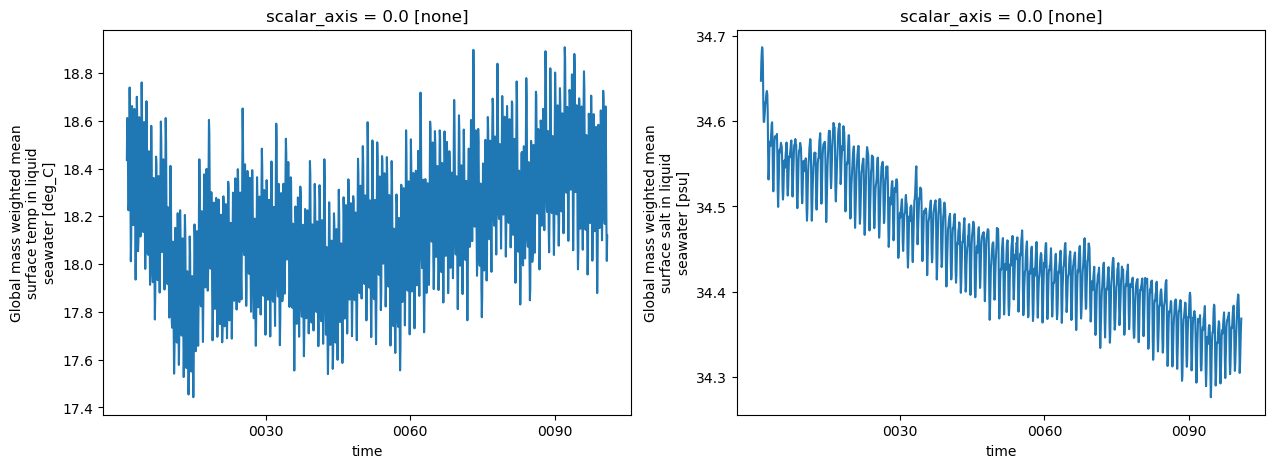

In [7]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(121)
data_scalar.temp_surface_ave.plot()
# Double spike from NH/SH seasonality (NH larger)

plt.subplot(122)
data_scalar.salt_surface_ave.plot()

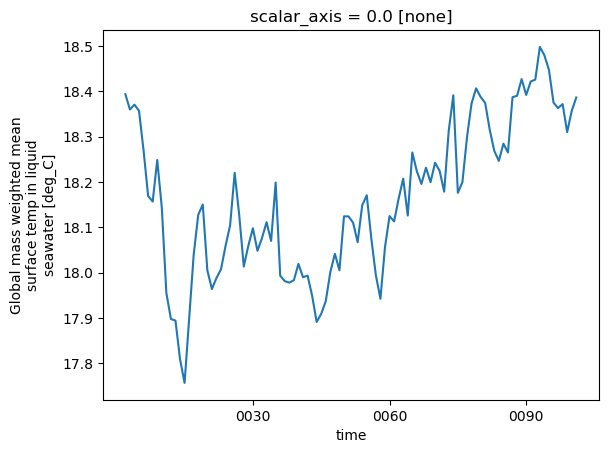

In [13]:
data_scalar.temp_surface_ave.resample(time='Y').mean().plot()

In [8]:
# Ocean data
path_ocean = np.sort(glob.glob(path_data + 'ocean-ym_*'))

# Temp
data_ocean_temp = xr.open_dataset(path_data + 'ocean-ym_0001_01.nc').temp.sel(st_ocean=0, method='nearest')
for ii in range(1, len(path_ocean)):
    data_ocean_temp = xr.concat([data_ocean_temp, xr.open_dataset(path_ocean[ii]).temp.sel(st_ocean=0, method='nearest')], dim='time')

In [9]:
# Salt
data_ocean_salt = xr.open_dataset(path_data + 'ocean-ym_0001_01.nc').salt.sel(st_ocean=0, method='nearest')
for ii in range(1, len(path_ocean)):
    data_ocean_salt = xr.concat([data_ocean_salt, xr.open_dataset(path_ocean[ii]).salt.sel(st_ocean=0, method='nearest')], dim='time')

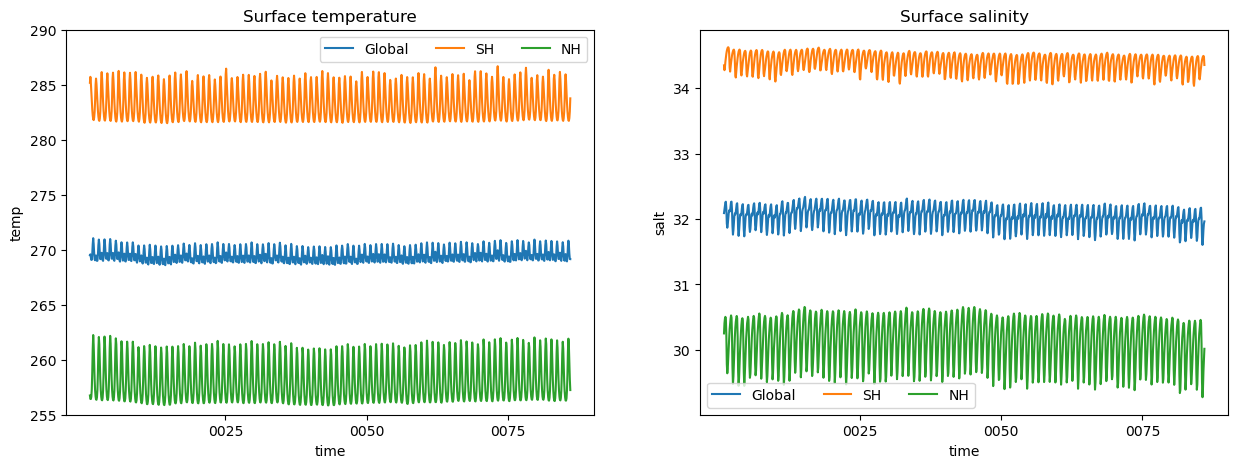

In [10]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(121)
data_ocean_temp.mean('xt_ocean').mean('yt_ocean').plot(label='Global')
data_ocean_temp.sel(yt_ocean=slice(-90,0)).mean('xt_ocean').mean('yt_ocean').plot(label='SH')
data_ocean_temp.sel(yt_ocean=slice(0,90)).mean('xt_ocean').mean('yt_ocean').plot(label='NH')
plt.legend(ncol=3)
plt.ylim(255, 290)
plt.title('Surface temperature')

plt.subplot(122)
data_ocean_salt.mean('xt_ocean').mean('yt_ocean').plot(label='Global')
data_ocean_salt.sel(yt_ocean=slice(-90,0)).mean('xt_ocean').mean('yt_ocean').plot(label='SH')
data_ocean_salt.sel(yt_ocean=slice(0,90)).mean('xt_ocean').mean('yt_ocean').plot(label='NH')
plt.legend(ncol=3)
# plt.ylim(255, 290)
plt.title('Surface salinity');

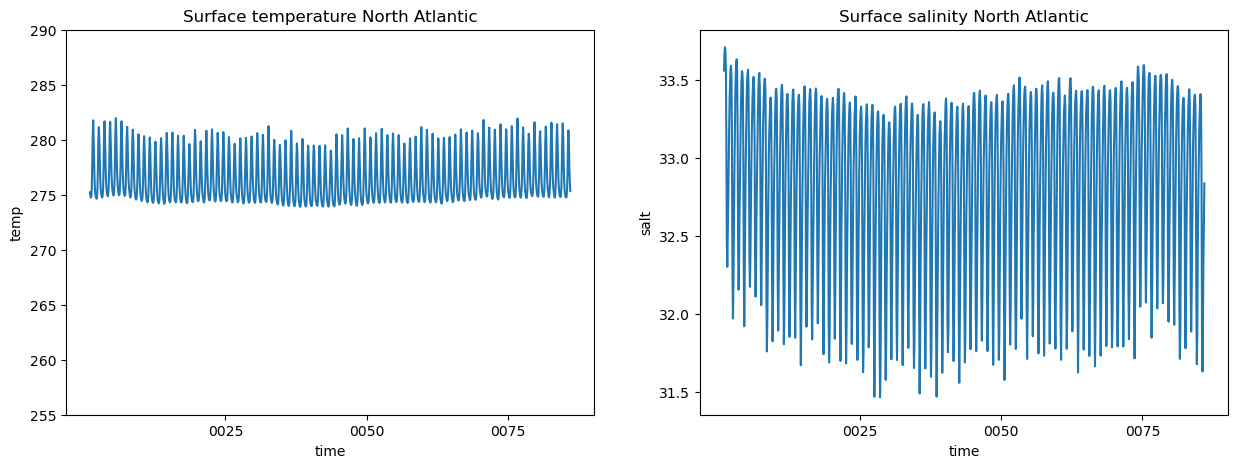

In [11]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(121)
data_ocean_temp.sel(yt_ocean=slice(45,90)).sel(xt_ocean=slice(-75, 50)).mean('xt_ocean').mean('yt_ocean').plot()
plt.ylim(255, 290)
plt.title('Surface temperature North Atlantic')

plt.subplot(122)
data_ocean_salt.sel(yt_ocean=slice(45,90)).sel(xt_ocean=slice(-75, 50)).mean('xt_ocean').mean('yt_ocean').plot()
# plt.ylim(255, 290)
plt.title('Surface salinity North Atlantic');

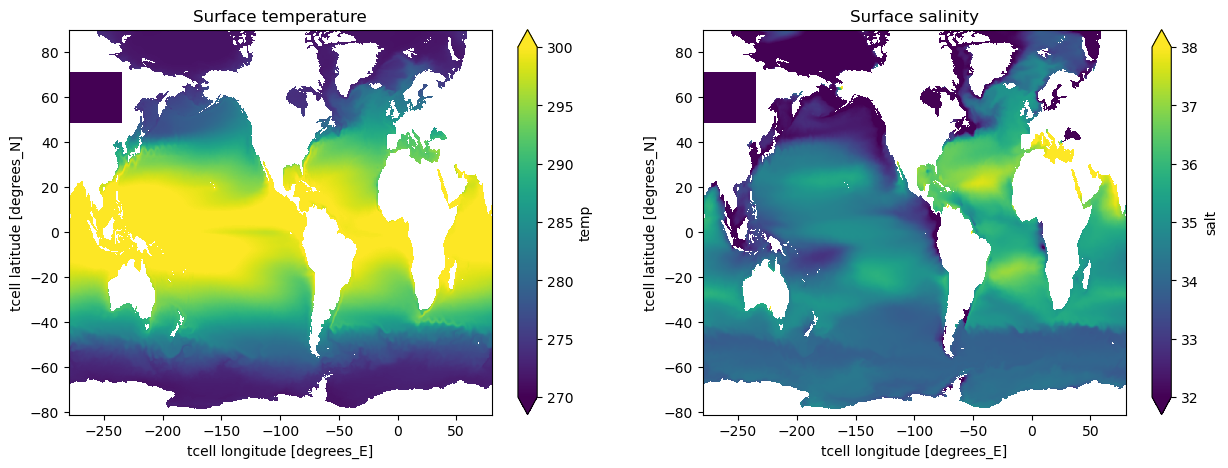

In [26]:
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
data_ocean_temp.sel(time=slice('0041-01-01','0050-12-31')).mean('time').plot(vmin=270, vmax=300)
plt.title('Surface temperature')

plt.subplot(122)
data_ocean_salt.sel(time=slice('0041-01-01','0050-12-31')).mean('time').plot(vmin=32, vmax=38)
plt.title('Surface salinity');

Mixed layer depth

In [14]:
data_month_mld = xr.open_dataset(path_data + 'ocean_month-ym_0001_01.nc').mld
for ii in range(1, len(path_ocean_month)):
    data_month_mld = xr.concat([data_month_mld, xr.open_dataset(path_ocean_month[ii]).mld], dim='time')

Text(0.5, 1.0, 'Mixed layer depth')

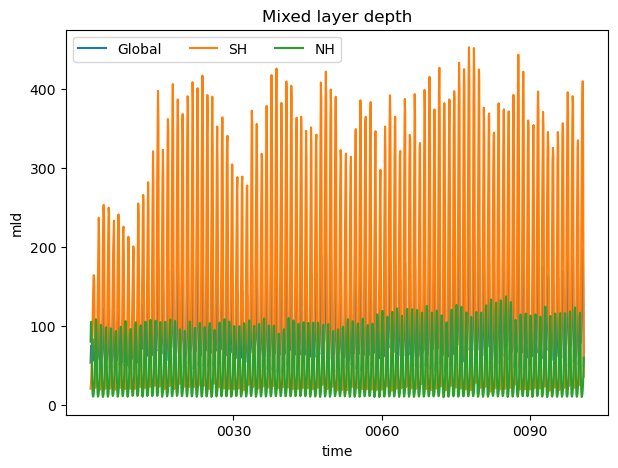

In [16]:
fig = plt.figure(figsize=(7, 5))

data_month_mld.mean('xt_ocean').mean('yt_ocean').plot(label='Global')
data_month_mld.sel(yt_ocean=slice(-90,0)).mean('xt_ocean').mean('yt_ocean').plot(label='SH')
data_month_mld.sel(yt_ocean=slice(0,90)).mean('xt_ocean').mean('yt_ocean').plot(label='NH')
plt.legend(ncol=3)
# plt.ylim(255, 290)
plt.title('Mixed layer depth')

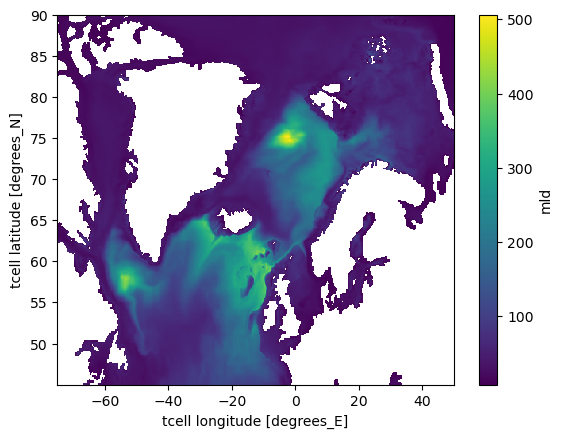

In [67]:
# First 10 years
data_month_mld.sel(yt_ocean=slice(45,90)).sel(xt_ocean=slice(-75, 50)).mean('time').plot()

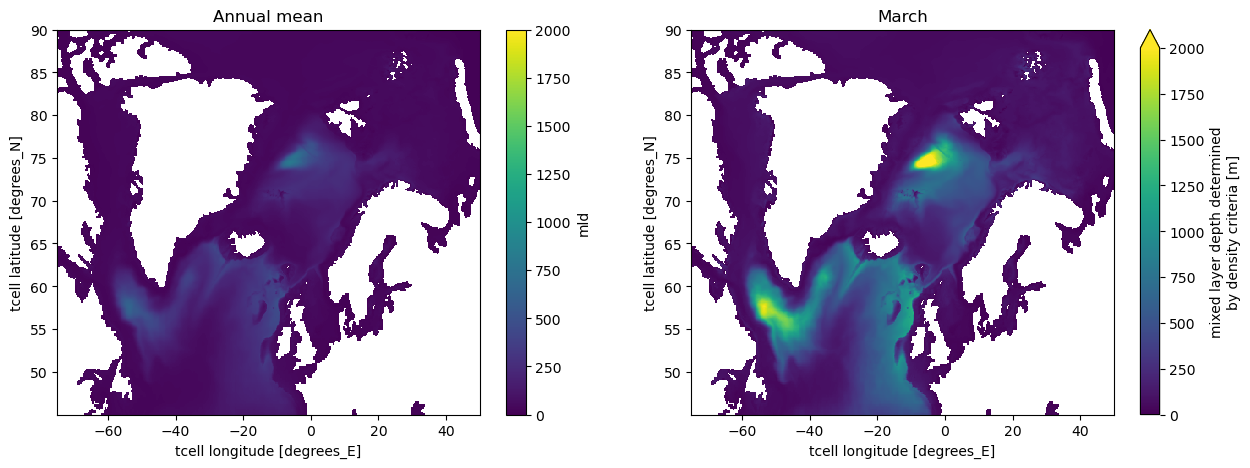

In [14]:
fig = plt.figure(figsize=(15,5))

# Annual mean
plt.subplot(121)
data_month_mld.sel(yt_ocean=slice(45,90)).sel(xt_ocean=slice(-75, 50)).mean('time').plot(vmin=0, vmax=2000)
plt.title('Annual mean')

# March values
plt.subplot(122)
tmp = data_month_mld.sel(yt_ocean=slice(45,90)).sel(xt_ocean=slice(-75, 50)).groupby('time.month').mean('time',skipna=True)
tmp[2,...].plot(vmin=0, vmax=2000)
plt.title('March');

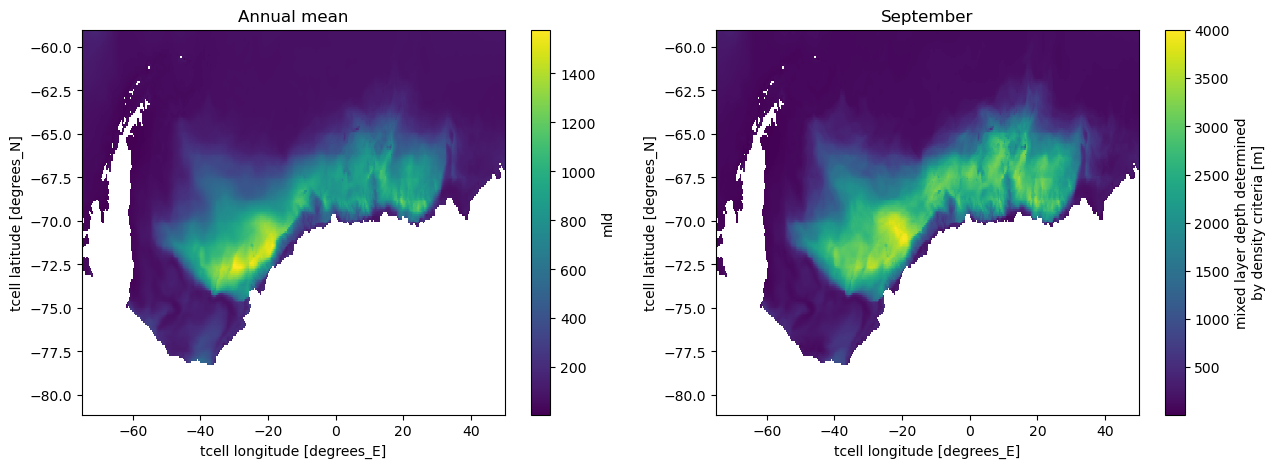

In [14]:
fig = plt.figure(figsize=(15,5))

# Annual mean
plt.subplot(121)
data_month_mld.sel(yt_ocean=slice(-90,-59)).sel(xt_ocean=slice(-75, 50)).mean('time').plot()
plt.title('Annual mean')

# March values
plt.subplot(122)
tmp = data_month_mld.sel(yt_ocean=slice(-90,-59)).sel(xt_ocean=slice(-75, 50)).groupby('time.month').mean('time',skipna=True)
tmp[8,...].plot()
plt.title('September');

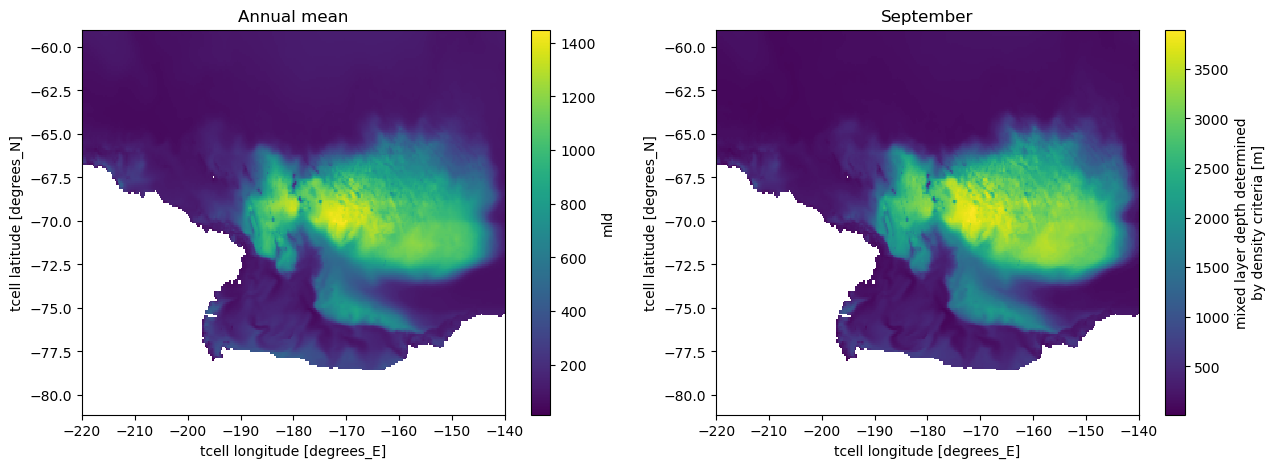

In [15]:
fig = plt.figure(figsize=(15,5))

# Annual mean
plt.subplot(121)
data_month_mld.sel(yt_ocean=slice(-90,-59)).sel(xt_ocean=slice(-220, -140)).mean('time').plot()
plt.title('Annual mean')

# March values
plt.subplot(122)
tmp = data_month_mld.sel(yt_ocean=slice(-90,-59)).sel(xt_ocean=slice(-220, -140)).groupby('time.month').mean('time',skipna=True)
tmp[8,...].plot()
plt.title('September');

Mld from previous CM2-025 run, first 25 years

In [5]:
def get_mld_max(expt, session, start_time, end_time, frequency='1 monthly'):
    
    mld = cc.querying.getvar(expt, 'mld', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
    mld = mld.sel(time=slice(start_time, end_time))
    #mld_max = mld.resample(time='Y').max()
    
    return mld#_max.compute()

In [ ]:
session_CM2 = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'

mld_CM2_025 = get_mld_max(expt_CM2_025, session_CM2, start_time='0050-01-01', end_time='0065-12-31')

In [13]:
mld_CM2_025_NA = mld_CM2_025.sel(yt_ocean=slice(45,90)).sel(xt_ocean=slice(-75, 50)).load()

In [14]:
mld_CM2_025_WS = mld_CM2_025.sel(yt_ocean=slice(-90,-59)).sel(xt_ocean=slice(-75, 50)).load()

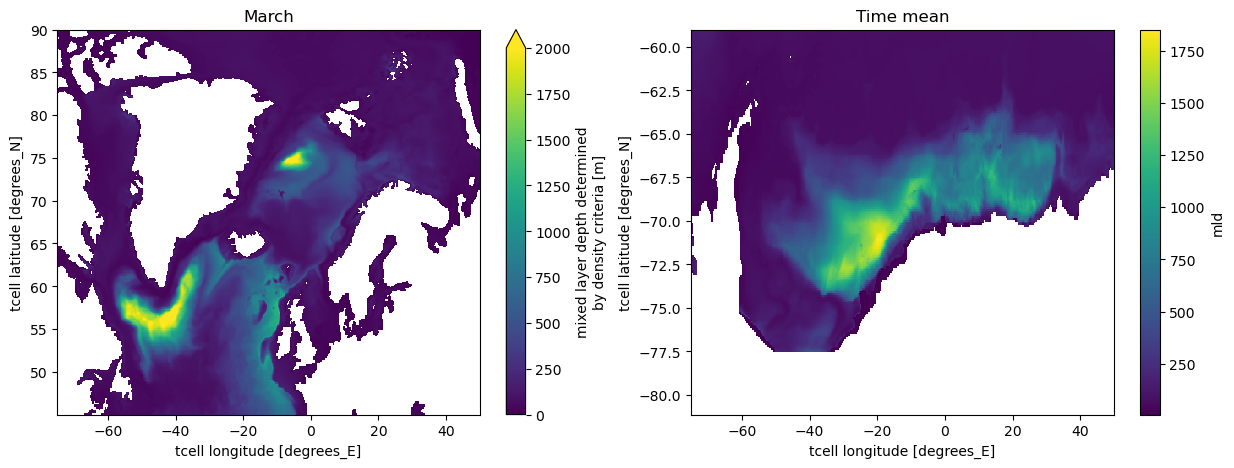

In [15]:
fig = plt.figure(figsize=(15,5))

# Annual mean, NA
plt.subplot(121)
# mld_CM2_025_NA.mean('time').plot(vmin=0, vmax=2000)
tmp = mld_CM2_025_NA.groupby('time.month').mean('time',skipna=True)
tmp[2,...].plot(vmin=0, vmax=2000)
plt.title('March')

# Annual mean, WS
plt.subplot(122)
mld_CM2_025_WS.mean('time').plot()
plt.title('Time mean');

### AMOC

In [7]:
%%time
latitude = 26
xt_slice = slice(-103, -5)

# First data file
rho_start = xr.open_dataset(path_data + 'ocean-ym_0001_01.nc').ty_trans_rho
rho_start = rho_start.sel(grid_xt_ocean=xt_slice).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
psi_amoc_sum = rho_start.cumsum('potrho') - rho_start.sum('potrho')

rho_gm_start = xr.open_dataset(path_data + 'ocean-ym_0001_01.nc').ty_trans_rho_gm
rho_gm_start = rho_gm_start.sel(grid_xt_ocean=xt_slice).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9

psi_amoc_sum = psi_amoc_sum + rho_gm_start

# Now repeat for rest
for ii in range(1, len(path_ocean_ym)):
    rho_tmp = xr.open_dataset(path_ocean_ym[ii]).ty_trans_rho
    rho_tmp = rho_tmp.sel(grid_xt_ocean=xt_slice).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_amoc_sum_tmp = rho_tmp.cumsum('potrho') - rho_tmp.sum('potrho')

    rho_gm_tmp = xr.open_dataset(path_ocean_ym[ii]).ty_trans_rho_gm
    rho_gm_tmp = rho_gm_tmp.sel(grid_xt_ocean=xt_slice).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9

    psi_amoc_sum_tmp = psi_amoc_sum_tmp + rho_gm_tmp

    psi_amoc_sum = xr.concat([psi_amoc_sum, psi_amoc_sum_tmp], dim='time')
        # data_ym_var = xr.concat([data_ym_var, xr.open_dataset(path_ocean_ym[ii]).ty_trans_rho], dim='time')

CPU times: user 39min 20s, sys: 8min 49s, total: 48min 9s
Wall time: 52min 59s


In [9]:
psi_amoc_sum.to_netcdf('/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/Comparison_ACCESS_CM2_025_new/' + 'psi_amoc_sum_CM2_025_new.nc')

In [15]:
data1 = xr.open_dataarray('/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/' + 'psi_AMOC_26N_annual.nc')

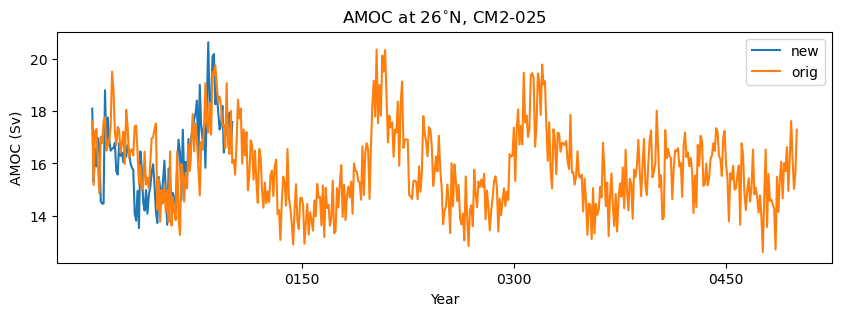

In [19]:
fig = plt.figure(figsize=(10,3))
psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean().plot(label='new')
data1.plot(label='orig')
plt.legend()
plt.title('AMOC at 26$^{\circ}$N, CM2-025')
plt.ylabel('AMOC (Sv)')
plt.xlabel('Year');

In [16]:
data1

<xarray.DataArray (time: 499)>
[499 values with dtype=float32]
Coordinates:
  * time           (time) object 0001-12-31 00:00:00 ... 0499-12-31 00:00:00
    grid_yu_ocean  float64 ...